# Research on RAFT (Retrieval Augmented Fine Tuning)

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('..//Data/medquad.csv')
data.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [2]:
data.columns

Index(['question', 'answer', 'source', 'focus_area'], dtype='object')

In [3]:
data.source.value_counts()

GHR                  5430
GARD                 5394
NIDDK                1192
NINDS                1088
MPlusHealthTopics     981
NIHSeniorHealth       769
CancerGov             729
NHLBI                 559
CDC                   270
Name: source, dtype: int64

In [4]:
focus = data.focus_area.value_counts()
len(focus) # 5126 Focus areas of medicine

5126

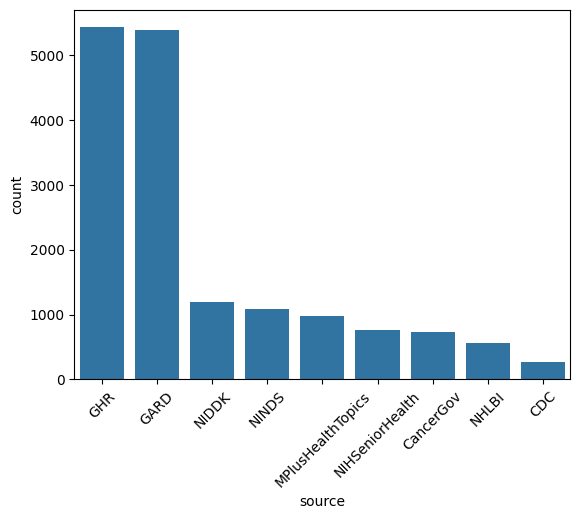

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(
    data = data,
    x = "source",
    order = data["source"].value_counts().index
)

plt.xticks(rotation=45)
plt.show()

### Preprocessing Dataset for LLM

In [2]:
data['question'] = [str(x).replace(':',' ') for x in data['question']]
data['answer'] = [str(x).replace(':', ' ') for x in data['answer']]
data['source'] = [str(x).replace(':', ' ') for x in data['source']]

data

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
...,...,...,...,...
16408,What is (are) Diabetic Neuropathies The Nerve...,Focal neuropathy appears suddenly and affects ...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...
16409,How to prevent Diabetic Neuropathies The Nerv...,The best way to prevent neuropathy is to keep ...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...
16410,How to diagnose Diabetic Neuropathies The Ner...,Doctors diagnose neuropathy on the basis of sy...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...
16411,What are the treatments for Diabetic Neuropath...,The first treatment step is to bring blood glu...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...


In [9]:
data = data.drop_duplicates()
data['combined_text'] = data['question'] + " " + data["answer"]
data['combined_text'] = data["combined_text"].str.replace('\n', ' ', regex=True)
data['combined_text'] = data['combined_text'].str.replace('  ', ' ')
data['combined_text']
data

,question,answer,source,focus_area,combined_text
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,What is (are) Glaucoma ? Glaucoma is a group o...
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,What causes Glaucoma ? Nearly 2.7 million peop...
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma,What are the symptoms of Glaucoma ? Symptoms o...
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma,What are the treatments for Glaucoma ? Althoug...
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,What is (are) Glaucoma ? Glaucoma is a group o...
...,...,...,...,...,...
16408,What is (are) Diabetic Neuropathies The Nerve...,Focal neuropathy appears suddenly and affects ...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...,What is (are) Diabetic Neuropathies The Nerve ...
16409,How to prevent Diabetic Neuropathies The Nerv...,The best way to prevent neuropathy is to keep ...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...,How to prevent Diabetic Neuropathies The Nerve...
16410,How to diagnose Diabetic Neuropathies The Ner...,Doctors diagnose neuropathy on the basis of sy...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...,How to diagnose Diabetic Neuropathies The Nerv...
16411,What are the treatments for Diabetic Neuropath...,The first treatment step is to bring blood glu...,NIDDK,Diabetic Neuropathies: The Nerve Damage of Dia...,What are the treatments for Diabetic Neuropath...


### RAFT on Gemma 2B

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from typing import List, Dict 
from tqdm import tqdm 
import random
import gc
import os
from dataclasses import dataclass
from accelerate import Accelerator

### Creating Embeddings

In [4]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [5]:
import warnings 
warnings.filterwarnings('ignore')

In [14]:
encoder = HuggingFaceEmbeddings(
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
)

In [ ]:
vector_store = FAISS.from_texts(
    data["combined_text"].tolist(),
    embedding=encoder
)

type(vector_store)

In [ ]:
vector_store = FAISS.from_documents(data,embeddings)

In [ ]:
vector_store.similarity_search("What is Acne ?")

In [25]:
# %pip install bitsandbytes

## RAFT Time

In [24]:
# RAFT Configuration : 
# BnB Config: 
import torch
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [30]:
from openai import OpenAI

llm = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key= "lm-studio",
    # model_name = "gemma-2-2b-instruct",
    # temperature = 0.7
)

In [32]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQAWithSourcesChain

template = """
You are a medical expert and an assistant for question-answering tasks.
You are given a question and you need to answer it based on the retrieved context.
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
Answer sufficiently in about 100 words and be precise.

Context: {context}
Question: {question}
Answer: {answer}

Sources: {sources}
"""

rag_prompt = PromptTemplate(
    # input_variables=["context", "question", "answer", "sources"],
    template=template,
)

In [40]:
from langchain_core.runnables import RunnablePassthrough

llm = RunnablePassthrough(
    base_url = "http://localhost:1234/v1",
    api_key = "lm-studio"
)

In [43]:
raft_chain = RetrievalQAWithSourcesChain.from_llm(
    llm = llm,
    retreiver = vector_store.as_retriever(search_kwargs={"k": 3}),
    prompt = rag_prompt,
    question_prompt = question_prompt,
    combine_prompt = combine_prompts
)

NameError: name 'question_prompt' is not defined

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import Dataset
import faiss
import numpy as np
from tqdm import tqdm

model_name = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

df = pd.read_csv('..//Data//medquad.csv')

# Load FAISS index (assuming you already have this)
dimension = 768  # or whatever your embedding dimension is
# faiss_index = faiss.read_index("your_faiss_index.index")
faiss_index = vector_store

def retrieve_similar_contexts(query, k=3):
    # Get query embedding (you'll need to implement this based on how you created your FAISS index)
    query_embedding = get_query_embedding(query)  
    distances, indices = faiss_index.search(query_embedding.reshape(1, -1), k)
    return [df.iloc[idx]['answer'] for idx in indices[0]]  # Return relevant contexts

# Create RAFT dataset
class RAFTDataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers
        
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        
        # Retrieve relevant contexts
        contexts = retrieve_similar_contexts(question)
        
        # Create RAFT prompt
        prompt = f"""Below are relevant medical contexts followed by a question. 
        Please provide a comprehensive answer based on the given contexts.

        Contexts:
        {' '.join(contexts)}

        Question: {question}
        Answer: {self.answers[idx]}
        """
        
        # Tokenize
        encoded = tokenizer(
            prompt,
            truncation=True,
            max_length=512,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "labels": encoded["input_ids"].squeeze()
        }

# Prepare dataset
questions = df['question'].tolist()
answers = df['answer'].tolist()

raft_dataset = RAFTDataset(questions, answers)
train_dataloader = DataLoader(raft_dataset, batch_size=4, shuffle=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./raft_gemma_medical",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    learning_rate=2e-5,
    logging_steps=100,
    save_steps=500,
    evaluation_strategy="no"
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=raft_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([f['input_ids'] for f in data]),
                               'attention_mask': torch.stack([f['attention_mask'] for f in data]),
                               'labels': torch.stack([f['labels'] for f in data])}
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./raft_gemma_medical_final")

# Test the model
def generate_answer(question):
    contexts = retrieve_similar_contexts(question)
    prompt = f"""Below are relevant medical contexts followed by a question. 
    Please provide a comprehensive answer based on the given contexts.

    Contexts:
    {' '.join(contexts)}

    Question: {question}
    Answer:"""
    
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(
        **inputs,
        max_length=200,
        temperature=0.7,
        num_return_sequences=1
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test example
test_question = "What is glaucoma?"
print(generate_answer(test_question))